# INST447 Final Project

##  IMDb JSON file + OMDb API 

Research Question: What factors are associated with higher-rated and more commercially successful movies from 2000–2022?



In [2]:
import json
import pandas as pd
import requests
import time

records = [] # list to store movie records in JSON file line by line 

with open("imdb_movies_2000to2022.prolific.json", "r") as file_connection:
    for line in file_connection:
        records.append(json.loads(line))

imdb_df = pd.DataFrame(records) # initializing a data frame from the list of dictionaries in JSON (each row is a moviel each key is a column)


# flattening rating fields

imdb_df["imdb_rating"] = imdb_df["rating"].apply(
    lambda x: x.get("avg") if isinstance(x, dict) else None # go through rating dictionary and process each row for average IMBb rating (new column) if value is a dictionary
)
imdb_df["imdb_votes"] = imdb_df["rating"].apply(
    lambda x: x.get("votes") if isinstance(x, dict) else None # get number of votes in a new column
)

API_KEY = "1d9a5fa1"

def fetch_omdb_data(imdb_id): # function to fetch OMDb data for a movie
    url = "https://www.omdbapi.com/"
    parameters = {
        "apikey": API_KEY, # authenticate
        "i": imdb_id, # IMDB ID used to identify the movie 
        "plot": "short" # short movie plot summary 
    }
    request = requests.get(url, params=parameters) # GET request to API with specified parameters
    return request.json() # return API response as dictionary (JSON format)

# empty list to store OMDb responses

omdb_records = []

for imdb_id in imdb_df["imdb_id"].head(200): # iterate over first 200 IMDb IDs (limit requests to avoid rate limits)
    result = fetch_omdb_data(imdb_id) # response fetched for every ID
    if result.get("Response") == "True": 
        omdb_records.append(result) # if API responses have been successful populate the list
    time.sleep(0.25) # pauses between requests

omdb_df = pd.DataFrame(omdb_records) # initiailizing a data frame from the OMDb API results

merged_df = imdb_df.merge( # merging two datasets using IMDb IDs
    omdb_df,
    left_on="imdb_id",
    right_on="imdbID",
    how="left" # left join to ensure all IMDb movies remain even if OMDb data is missing (only matches returned from the right)
)





In [3]:
print(omdb_df.columns)
omdb_df.head()


Index(['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director',
       'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster',
       'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'Type',
       'DVD', 'BoxOffice', 'Production', 'Website', 'Response'],
      dtype='object')


,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
0,Kate & Leopold,2001,PG-13,25 Dec 2001,118 min,"Comedy, Fantasy, Romance",James Mangold,"Steven Rogers, James Mangold","Meg Ryan, Hugh Jackman, Liev Schreiber",An English Duke from 1876 is inadvertently dra...,...,44,6.4,"92,720",tt0035423,movie,N/A,"$47,121,859",N/A,N/A,True
1,The Naked Monster,2005,N/A,22 Apr 2005,100 min,"Comedy, Horror, Sci-Fi","Wayne Berwick, Ted Newsom",Ted Newsom,"Kenneth Tobey, Brinke Stevens, R.G. Wilson","A brain-dead sheriff, a stolid secret agent an...",...,N/A,5.2,347,tt0088751,movie,N/A,N/A,N/A,N/A,True
2,Crime and Punishment,2002,Not Rated,01 Jun 2002,126 min,Drama,Menahem Golan,"Fyodor Dostoevsky, Menahem Golan","Crispin Glover, Vanessa Redgrave, John Hurt",A modern day adaptation of Dostoyevsky's class...,...,N/A,5.5,897,tt0096056,movie,N/A,N/A,N/A,N/A,True
3,For the Cause,2000,R,17 Dec 2002,100 min,"Action, Adventure, Drama","David Douglas, Tim Douglas","David Douglas, Christopher Salazar","Dean Cain, Thomas Ian Griffith, Justin Whalin",Earth is in a state of constant war and two co...,...,N/A,3.4,863,tt0113092,movie,N/A,N/A,N/A,N/A,True
4,Gang,2000,Not Rated,21 Apr 2000,167 min,"Action, Crime, Drama",Mazhar Khan,N/A,"Jackie Shroff, Nana Patekar, Kumar Gaurav","After falling prey to underworld, four friends...",...,N/A,6.3,272,tt0116391,movie,N/A,"$28,915",N/A,N/A,True


In [4]:
merged_df["Runtime"] = merged_df["Runtime"].str.replace(" min", "", regex=False) # remove the text "min" from runtime column values
merged_df["Runtime"] = pd.to_numeric(merged_df["Runtime"], errors="coerce") # change column values to numeric format, and missing/invalid values to NaN

# explode genres for analysis

genres_df = merged_df.explode("genres") # split multi-genre movies into one row per genre

genres_df = genres_df[ # removing missing or empty genre entries 
    genres_df["genres"].notna() &
    (genres_df["genres"].str.strip() != "")
]

genre_stats = (
    genres_df
    .groupby("genres")
    .agg(
        avg_rating=("imdb_rating", "mean"), # new genre data frame grouped by genres, sorted by avg ratings
        avg_votes=("imdb_votes", "mean"),
        count=("imdb_rating", "count")
    )
    .sort_values("avg_rating", ascending=False)
)


In [5]:
genre_stats

,avg_rating,avg_votes,count
genres,,,
Documentary,7.257259,844.194127,613
News,7.119048,193.476190,21
Biography,6.663486,54081.824427,786
History,6.602676,33243.160584,411
Sport,6.233894,24109.145658,357
Short,6.200000,199.000000,1
Music,6.191667,27435.120968,372
War,6.073585,32637.886792,212
Drama,6.032123,28544.036933,9585


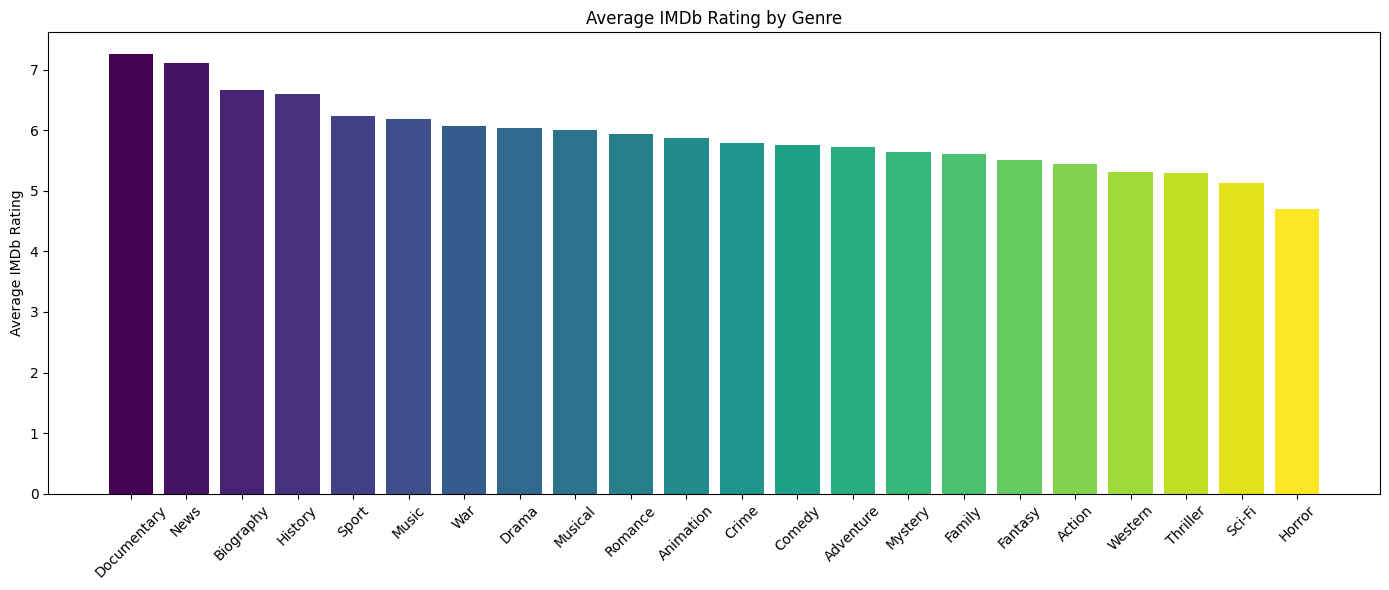

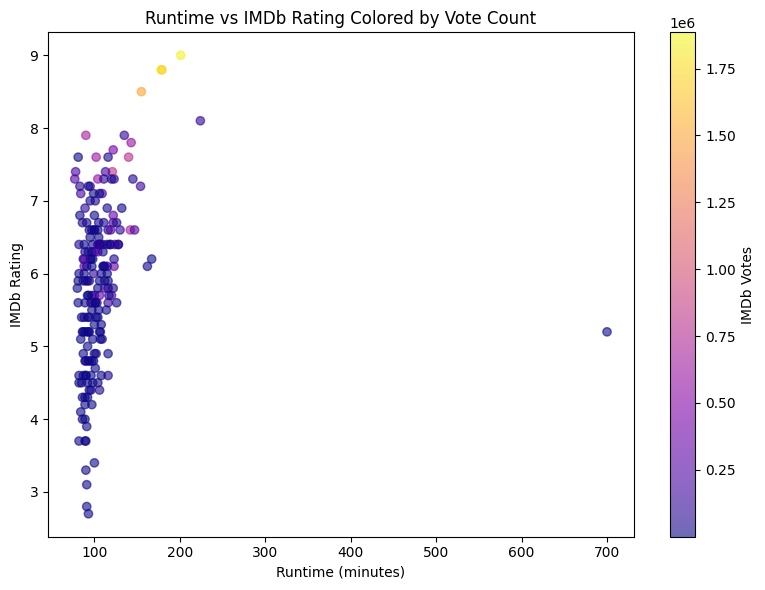

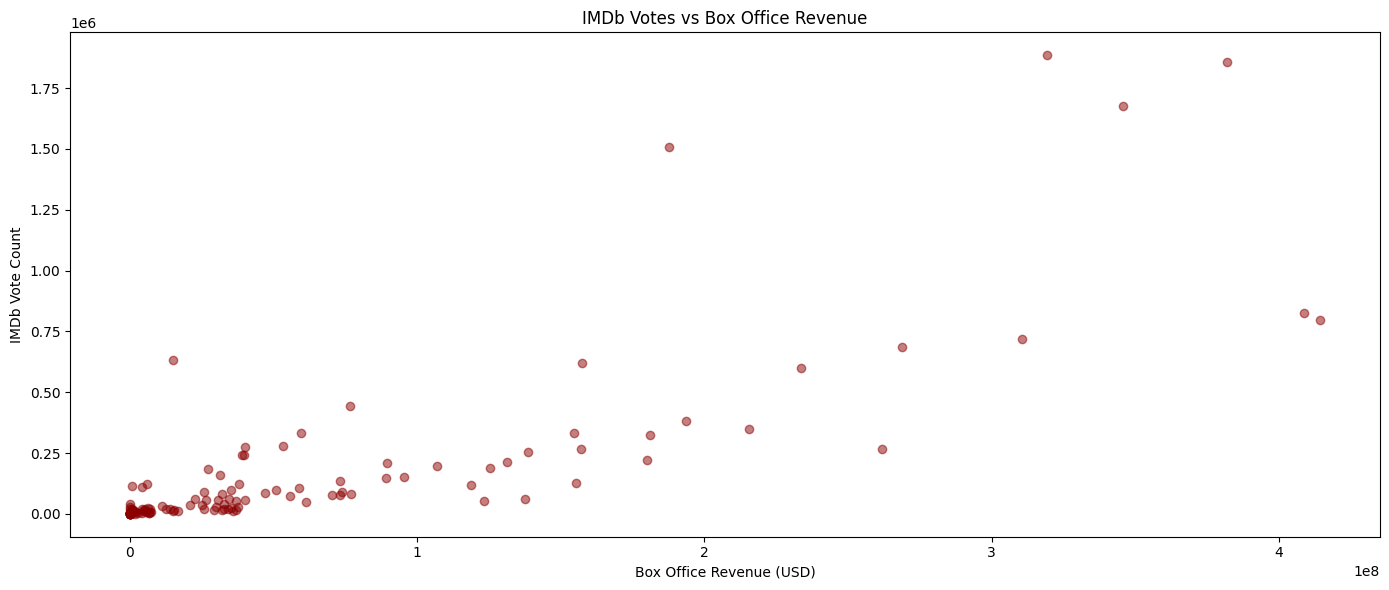

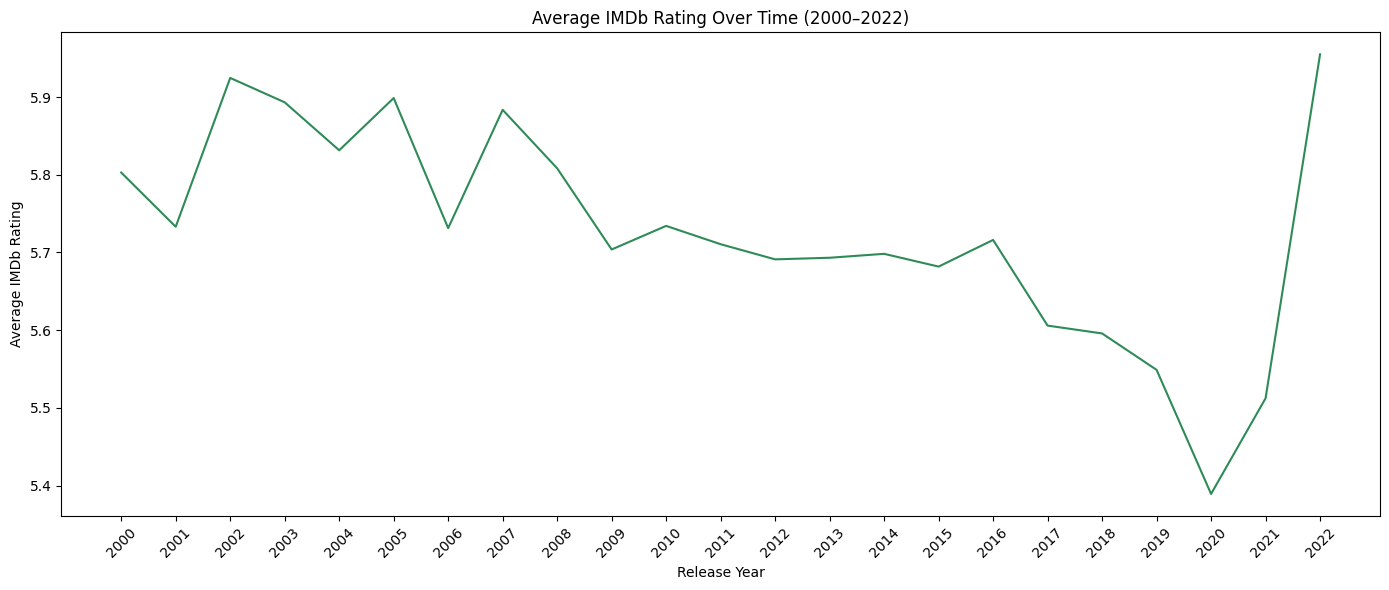

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# p1

top_genres = genre_stats[genre_stats["count"] > 10] # filter out genres with small sample sizes 

plt.figure(figsize=(14, 6))

colors = plt.cm.viridis(
    np.linspace(0, 1, len(top_genres)) # generate smooth color gradient usually a colormap for each genre
)

plt.bar( # average ratings by genre plotted with bars 
    top_genres.index,
    top_genres["avg_rating"],
    color=colors
)

plt.xticks(rotation=45)
plt.ylabel("Average IMDb Rating")
plt.title("Average IMDb Rating by Genre")
plt.tight_layout()
plt.show()


# p2 

plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    merged_df["Runtime"], # runtime vs rating scatterplot 
    merged_df["imdb_rating"],
    c=merged_df["imdb_votes"], # colored by vote count (popularity), mapped to color gradient
    cmap="plasma",
    alpha=0.6
)

plt.xlabel("Runtime (minutes)")
plt.ylabel("IMDb Rating")
plt.title("Runtime vs IMDb Rating Colored by Vote Count")
plt.colorbar(scatter, label="IMDb Votes") # color legend 
plt.tight_layout()
plt.show()


# p3

merged_df["BoxOffice_clean"] = ( # removing dollar sign and commas
    merged_df["BoxOffice"]
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

merged_df["BoxOffice_clean"] = pd.to_numeric( # convert box office revenue to numeric values 
    merged_df["BoxOffice_clean"], errors="coerce"
)

plt.figure(figsize=(14,6))
plt.scatter(
    merged_df["BoxOffice_clean"], # scatterplot for relation between commercial success and popularity 
    merged_df["imdb_votes"],
    color = "darkred",
    alpha=0.5
)
plt.xlabel("Box Office Revenue (USD)")
plt.ylabel("IMDb Vote Count")
plt.title("IMDb Votes vs Box Office Revenue")
plt.tight_layout()
plt.show()


# p4

yearly_ratings = merged_df.groupby("year")["imdb_rating"].mean() # average rating per release year (y/x)

plt.figure(figsize=(14,6))
plt.plot(yearly_ratings, color = "seagreen") # line plot for average rating per release year (trend over time)
plt.xlabel("Release Year")
plt.ylabel("Average IMDb Rating")
plt.title("Average IMDb Rating Over Time (2000–2022)")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()


